In [226]:
import os
os.listdir('./data')

['train_bfill_Filled(full).csv',
 'train_spec_checked(2016~2017).csv',
 'train_FeatureSelected(2016~2017).csv',
 'train_KnnFilled(2017~2018).csv',
 'train_KnnFilled(2016~2017).csv',
 'train_KnnFilled(2018~2019).csv',
 'train_KnnFilled(full).csv',
 'train_spec_checked(full).csv']

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
from tqdm import tqdm_notebook as tqdm

# load df

In [228]:
file_path = './data/train_bfill_Filled(full).csv'

In [229]:
df = pd.read_csv(file_path, index_col = 0, parse_dates = True)
print(df.shape)
df.head()

(193824, 93)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,...,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD
2016-05-09 00:00:00,400.0,401.957120,400.751866,402.250788,401.148767,401.0,400.050078,403.0,402.0,401.0,...,0.0,0.000005,4.051145,4.045683,6.484770,0.0,0.0,-1.000000,1.635186,0.051
2016-05-09 00:10:00,400.0,401.942713,400.949883,402.249145,401.000000,401.0,400.249800,403.0,402.0,401.0,...,0.0,0.000010,4.157856,4.152250,6.449888,0.0,0.0,-1.000000,1.625011,0.051
2016-05-09 00:20:00,400.0,401.900145,400.899767,402.101255,401.000000,401.0,400.100155,403.0,402.0,401.0,...,0.0,0.000014,4.208122,4.202449,6.440502,0.0,0.0,-0.898558,1.649780,0.051
2016-05-09 00:30:00,400.0,401.949936,400.900210,402.300333,401.000000,401.0,400.144695,403.0,402.0,401.0,...,0.0,0.000019,4.152321,4.146723,6.463649,0.0,0.0,-0.509010,1.635187,0.051
2016-05-09 00:40:00,400.0,402.000000,400.850037,402.176070,401.000000,401.0,400.405002,403.0,402.0,401.0,...,0.0,0.000024,4.016713,4.011298,6.414799,0.0,0.0,-0.992771,1.654259,0.051


In [230]:
df[df.columns[df.columns.str.contains('0755|211')]]

,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後)
2016-05-09 00:00:00,4.051145,4.045683,0.000000,0.000000
2016-05-09 00:10:00,4.157856,4.152250,0.000000,0.000000
2016-05-09 00:20:00,4.208122,4.202449,0.000000,0.000000
2016-05-09 00:30:00,4.152321,4.146723,0.000000,0.000000
2016-05-09 00:40:00,4.016713,4.011298,0.000000,0.000000
...,...,...,...,...
2020-01-14 23:10:00,4.062844,4.057367,1407.074137,1405.177243
2020-01-14 23:20:00,4.059323,4.053850,1407.000689,1405.103894
2020-01-14 23:30:00,4.067255,4.061772,1411.786722,1409.883474
2020-01-14 23:40:00,4.065271,4.059790,1406.828511,1404.931948


# drop2 columns

In [231]:
tag_sheet = pd.read_excel('tag盤點表.xlsx')
tag_sheet.loc[tag_sheet['TAG'].str.contains('0755|211')==True]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
27,28.0,MLPAP_FR-0755PV(轉換後),反應槽16K蒸氣輸出,流量,T/HR,不可控制因子,1分鐘2筆,0,25,***
29,30.0,MLPAP_FI-V211.PV(轉換後),副反應槽蒸氣輸出,流量,KG/HR,不可控制因子,1分鐘2筆,1000,6900,***


In [232]:
print(df.shape)
df = df.drop(['MLPAP_FR-0755.PV','MLPAP_FI-V211.PV'],axis=1)
print(df.shape)

(193824, 93)
(193824, 91)


In [233]:
df[df.columns[df.columns.str.contains('0757')]]

,MLPAP_TIC-0757A.PV,MLPAP_TI-0757B.PV,MLPAP_TIC-0757.PV
2016-05-09 00:00:00,399.700012,400.514472,1.635186
2016-05-09 00:10:00,399.700012,400.540553,1.625011
2016-05-09 00:20:00,399.734506,400.594478,1.649780
2016-05-09 00:30:00,399.799988,400.600006,1.635187
2016-05-09 00:40:00,399.799988,400.600006,1.654259
...,...,...,...
2020-01-14 23:10:00,296.458011,296.754481,0.544648
2020-01-14 23:20:00,296.102549,296.312035,0.429594
2020-01-14 23:30:00,295.631948,296.010352,0.757286
2020-01-14 23:40:00,295.196892,295.661895,0.920603


In [234]:
tag_sheet = pd.read_excel('tag盤點表.xlsx')
tag_sheet.loc[tag_sheet['TAG'].str.contains('0757')==True]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
4,5.0,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
88,89.0,MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,溫度,℃,可控制因子,1分鐘2筆,-3,3,***


In [235]:
temp = tag_sheet.loc[tag_sheet['TAG']=='MLPAP_TIC-0757A.PV',:].copy()
temp['TAG'] = 'MLPAP_TI-0757B.PV'
tag_sheet = tag_sheet.append(temp).reset_index(drop=True)

In [236]:
tag_sheet.loc[tag_sheet['TAG'].str.contains('0757')==True]

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
4,5.0,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****
88,89.0,MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,溫度,℃,可控制因子,1分鐘2筆,-3,3,***
93,5.0,MLPAP_TI-0757B.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****


# spec

In [237]:
df.columns = [str(i).replace('TJR','TI') for i in df.columns]
tag_sheet['TAG'] = [str(i).replace('TJR','TI') for i in tag_sheet['TAG'].values]

In [238]:
intersection = set(tag_sheet['TAG'].values) & set(df.columns.tolist())
spec = tag_sheet[tag_sheet['TAG'].isin(intersection)][['TAG','chinese','min','max']].set_index('TAG')
spec.loc['DATA OF USE','min'],spec.loc['DATA OF USE','max'] = 0,1
print(spec.shape[0])
print("保留的欄位")
spec

91
保留的欄位


,chinese,min,max
TAG,,,
MLPAP_TJC-0627.PV,OX預熱器出口溫度,140,160
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,160,200
MLPAP_FR-0632.PV,汽機風量,30,90
MLPAP_FQ-0619.PV,OX入料量,2000,8000
MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,345,365
...,...,...,...
MLPAP_TI-0762B2.PV,鹽浴溫度,345,375
MLPAP_PI-0658.PV,反應器入口壓力,200,500
MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,-3,3


# df 和 tag盤點表的斥集

In [239]:
print(set(df.columns.tolist())^set(tag_sheet['TAG'].values))
print(set(tag_sheet['TAG'].values)-set(df.columns.tolist()))
print(set(df.columns.tolist())-set(tag_sheet['TAG'].values))

{'nan', '第二模型使用'}
{'第二模型使用', 'nan'}
set()


In [240]:
df = df[spec.index.tolist()]
print(df.shape)

(193824, 91)


# column filter

In [241]:
def check_spec_col(df,spec):
    count = collections.defaultdict(int)
    intersection = set(list(df.columns))&set(list(spec.index))
    for col in tqdm(list(intersection)):
        lb, ub = spec.loc[col,'min'], spec.loc[col,'max']
        over_range = (df[col]<lb)|(df[col]>ub)
        count[col] += over_range.sum()
    return pd.DataFrame(count.values(),index=count.keys(),columns=['count'])['count']


MLPAP_PI-0658.PV     84348
MLPAP_PIC-0761.PV    38091
MLPAP_TI-0716A16     42900
MLPAP_TI-0716A19     45344
MLPAP_TI-0716A14     56443
                     ...  
MLPAP_TI-0716A05     53454
MLPAP_TI-0706B06     42945
MLPAP_TI-0706B07     42957
MLPAP_TI-0706B01     70909
MLPAP_TI-0706B16     42901
Name: count, Length: 91, dtype: int64


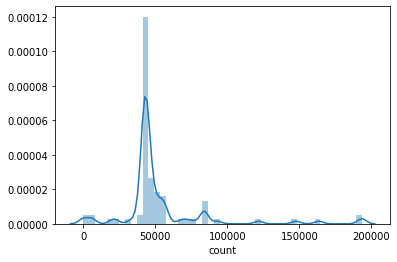

In [242]:
count = check_spec_col(df,spec)
print(count)
sns.distplot(count)
plt.show()

In [243]:
def plot_over_range(raw,spec):
    df = raw.copy()
    intersection = set(list(df.columns))&set(list(spec.index))
    for col in tqdm(list(intersection)):
        lb, ub = spec.loc[col,'min'], spec.loc[col,'max']
        over_range = (df[col]<lb)|(df[col]>ub)
        df.loc[over_range,col] = np.nan
    return df

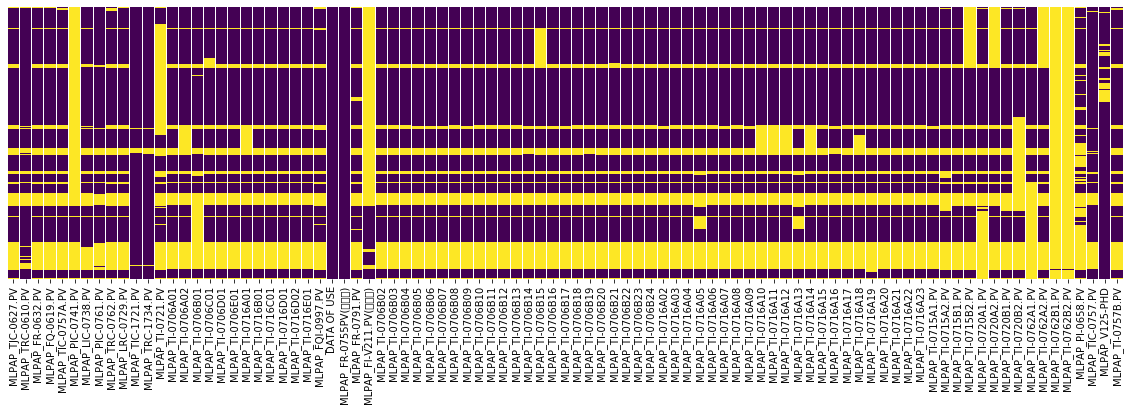

In [244]:
import warnings 
warnings.simplefilter('ignore')
fig = plt.figure(figsize=(20,5))
sns.heatmap(plot_over_range(df,spec).isnull(),yticklabels=False,cbar=False,cmap='viridis')

# columns wise delete

In [245]:
theshold = count.median()+1.5*count.std()
print(theshold)

90658.13222399227


In [246]:
remain_col = count.loc[count<theshold].index.tolist()
y_col = ['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV']
remain_col = list(set(remain_col)|set(y_col)) 
print(len(remain_col))

85


In [247]:
print(df.shape)
df = df[remain_col]
print(df.shape)

(193824, 91)
(193824, 85)


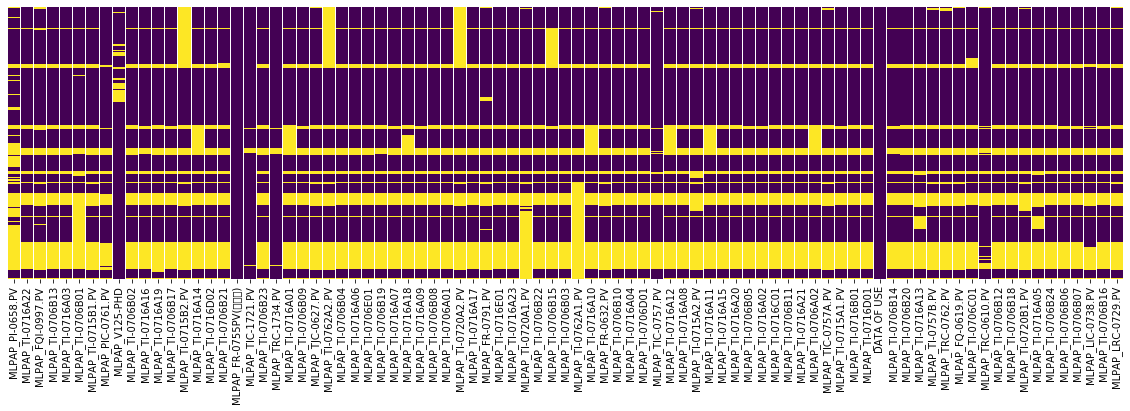

In [248]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(plot_over_range(df,spec).isnull(),yticklabels=False,cbar=False,cmap='viridis')

# OVER RANGE COUNT

In [249]:
def check_spec(df,spec):
    df['over_range_count'] = 0
    for col in tqdm(df.columns[:-1]):
        lb, ub = spec.loc[col,'min'],spec.loc[col,'max']
        over_range = (df[col]<lb)|(df[col]>ub)
        df.loc[over_range,'over_range_count'] += 1
    return df
df = check_spec(df,spec)
df.head()

,MLPAP_PI-0658.PV,MLPAP_TI-0716A22,MLPAP_FQI-0997.PV,MLPAP_TI-0706B13,MLPAP_TI-0716A03,MLPAP_TI-0706B01,MLPAP_TI-0715B1.PV,MLPAP_PIC-0761.PV,MLPAP_V125-PHD,MLPAP_TI-0706B02,...,MLPAP_TI-0706B18,MLPAP_TI-0720B1.PV,MLPAP_TI-0716A05,MLPAP_TI-0706B24,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_LIC-0738.PV,MLPAP_TI-0706B16,MLPAP_LRC-0729.PV,over_range_count
2016-05-09 00:00:00,-1.000000,401.0,0.0,401.0,400.100219,402.349811,399.684741,46.900002,0.051,400.0,...,401.050078,401.865110,400.0,402.0,401.148767,401.0,5.235951,402.050208,0.0,20
2016-05-09 00:10:00,-1.000000,401.0,0.0,401.0,400.050129,402.000000,399.625166,46.900002,0.051,400.0,...,401.050052,401.954911,400.0,402.0,401.000000,401.0,5.208001,402.000000,0.0,20
2016-05-09 00:20:00,-0.898558,401.0,0.0,401.0,400.149919,402.350189,399.670499,46.930040,0.051,400.0,...,401.000000,401.922669,400.0,402.0,401.000000,401.0,5.246516,402.000000,0.0,20
2016-05-09 00:30:00,-0.509010,401.0,0.0,401.0,400.099776,402.400044,399.697396,46.900002,0.051,400.0,...,401.099855,401.927230,400.0,402.0,401.000000,401.0,5.385347,402.000000,0.0,20
2016-05-09 00:40:00,-0.992771,401.0,0.0,401.0,400.199982,402.101425,399.775506,46.900002,0.051,400.0,...,401.142628,401.900039,400.0,402.0,401.000000,401.0,5.306820,402.000000,0.0,20


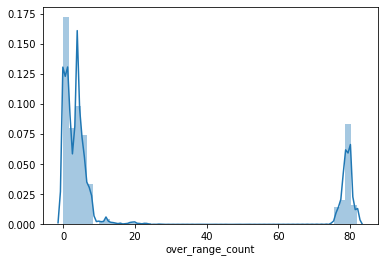

In [250]:
sns.distplot(df['over_range_count'])

Text(0, 0.5, 'over_range_count')

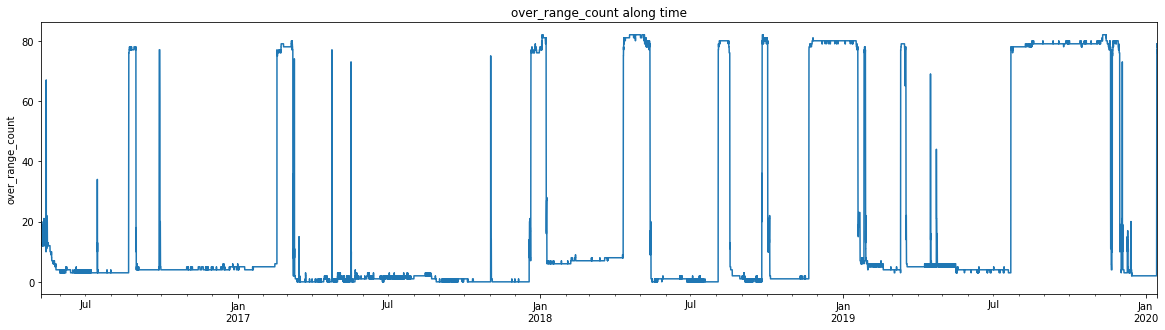

In [251]:
fig = plt.figure(figsize=(20,5))
df['over_range_count'].plot(title='over_range_count along time')
plt.ylabel('over_range_count')

# add target

In [252]:
df[df.columns[df.columns.str.contains('0997|0619')]]

,MLPAP_FQI-0997.PV,MLPAP_FQ-0619.PV
2016-05-09 00:00:00,0.0,0.0
2016-05-09 00:10:00,0.0,0.0
2016-05-09 00:20:00,0.0,0.0
2016-05-09 00:30:00,0.0,0.0
2016-05-09 00:40:00,0.0,0.0
...,...,...
2020-01-14 23:10:00,0.0,0.0
2020-01-14 23:20:00,0.0,0.0
2020-01-14 23:30:00,0.0,0.0
2020-01-14 23:40:00,0.0,0.0


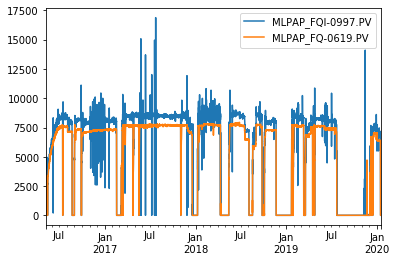

In [253]:
df[df.columns[df.columns.str.contains('0997|0619')]].plot()

# select 0619 and 0997 is vaild's part

In [254]:
df['target'] = 0.9

In [255]:
# 0619
lb,ub = tag_sheet[tag_sheet['TAG']=='MLPAP_FQ-0619.PV'][['min','max']].values[0]
print(lb,ub)
c1 = (df['MLPAP_FQ-0619.PV']>lb)&(df['MLPAP_FQ-0619.PV']<ub)

# 0997
lb,ub = tag_sheet[tag_sheet['TAG']=='MLPAP_FQI-0997.PV'][['min','max']].values[0]
print(lb,ub)
c2 = (df['MLPAP_FQI-0997.PV']>lb)&(df['MLPAP_FQI-0997.PV']<ub)

# target not vaild is np.nan
df.loc[~(c1&c2),'target'] = np.nan

2000 8000
5000 10000


In [256]:
df.loc[c1&c2,'target'] = df['MLPAP_FQ-0619.PV']/df['MLPAP_FQI-0997.PV']
df = df.drop(['MLPAP_FQ-0619.PV','MLPAP_FQI-0997.PV'],axis=1)

# spec target

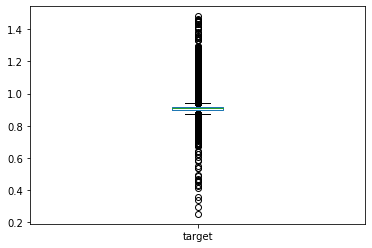

In [257]:
df['target'].dropna().plot(kind='box')

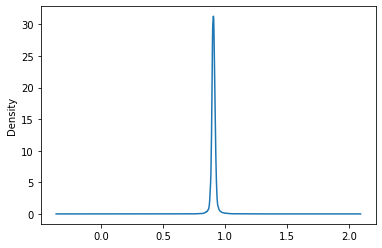

In [258]:
df['target'].dropna().plot(kind='kde')

# IQR

0.8738288162274948 0.9418043223250774


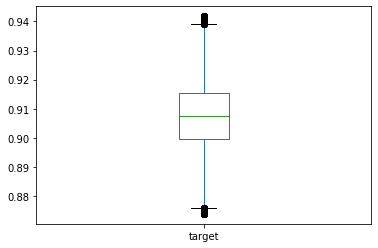

In [259]:
Q75 = df['target'].quantile(0.75)
Q25 = df['target'].quantile(0.25)
IQR = Q75 - Q25 
ub = Q75 + 1.5*IQR
lb = Q25 - 1.5*IQR
print(lb,ub)

out = (df['target']<lb)|(df['target']>ub)
df.loc[out,'target'] = np.nan

df['target'].plot(kind='box')

In [260]:
df['target'].isnull().sum()

59024

# save

In [261]:
df.head()

,MLPAP_PI-0658.PV,MLPAP_TI-0716A22,MLPAP_TI-0706B13,MLPAP_TI-0716A03,MLPAP_TI-0706B01,MLPAP_TI-0715B1.PV,MLPAP_PIC-0761.PV,MLPAP_V125-PHD,MLPAP_TI-0706B02,MLPAP_TI-0716A16,...,MLPAP_TI-0720B1.PV,MLPAP_TI-0716A05,MLPAP_TI-0706B24,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_LIC-0738.PV,MLPAP_TI-0706B16,MLPAP_LRC-0729.PV,over_range_count,target
2016-05-09 00:00:00,-1.000000,401.0,401.0,400.100219,402.349811,399.684741,46.900002,0.051,400.0,401.253627,...,401.865110,400.0,402.0,401.148767,401.0,5.235951,402.050208,0.0,20,NaN
2016-05-09 00:10:00,-1.000000,401.0,401.0,400.050129,402.000000,399.625166,46.900002,0.051,400.0,401.361592,...,401.954911,400.0,402.0,401.000000,401.0,5.208001,402.000000,0.0,20,NaN
2016-05-09 00:20:00,-0.898558,401.0,401.0,400.149919,402.350189,399.670499,46.930040,0.051,400.0,401.899611,...,401.922669,400.0,402.0,401.000000,401.0,5.246516,402.000000,0.0,20,NaN
2016-05-09 00:30:00,-0.509010,401.0,401.0,400.099776,402.400044,399.697396,46.900002,0.051,400.0,401.849886,...,401.927230,400.0,402.0,401.000000,401.0,5.385347,402.000000,0.0,20,NaN
2016-05-09 00:40:00,-0.992771,401.0,401.0,400.199982,402.101425,399.775506,46.900002,0.051,400.0,401.599924,...,401.900039,400.0,402.0,401.000000,401.0,5.306820,402.000000,0.0,20,NaN


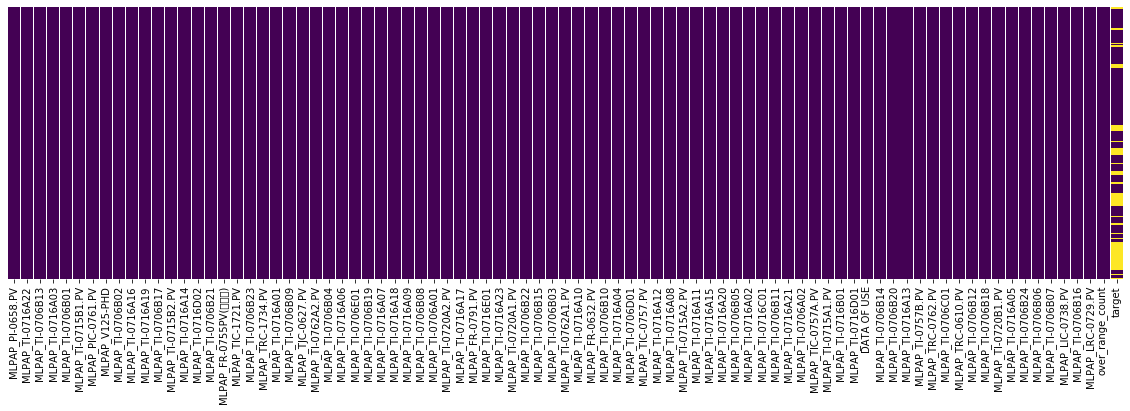

In [262]:
fig = plt.figure(figsize=(20,5))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [263]:
df.to_csv('./data/train_spec_checked_and_add_target(full).csv')